# Evaluation on Simulated Signals

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import multiprocessing
import time

from IPython.display import clear_output
warnings.filterwarnings('ignore')

In [2]:
from src.sigsimulation import *
from src.robustper import robustper_wrap, mltproc_robustper_wrap
from src.baywatch import baywatch_wrap, mltproc_baywatch_wrap
from src.statsbased import stats_wrap, mltproc_stats_wrap
from src.upnsca import upnsca_wrap, mltproc_upnsca_wrap
from src.bcndetection import bcndetection_wrap, mltproc_bcndetection_wrap

## Omitting Noise Simulation

In [4]:
perl = [10]
std = 0.
omtl = [i for i in range(0, 105, 5)]
cnt = 100

datarootdir = "data/omt"
datafilefmt = "per_{}_omt_{}.parquet"

# load pregenerated signal, set to True to regenerate simulated signals
regenerate = False

#### Multiprocessing to reduce the computation time
- set multiproc=False to disable multiprocessing

In [5]:
multiproc = True
processors = 16

#### Algorithm Evaluation
- Run the following blocks to regenerate results for STATS-based, UPNSCA, BAYWATCH and our Proposed methods.
- The unofficial implementation of Robust period is very slow. It usually take 2 minutes to process one time seires, as a result, it would take hours to complete the Gaussian noise evaluation section. Therefore, we read the robustperiod results from our previous evaluation here for convenience purporse.
- We provide a demo and the whole re-runing code at the end of this notebook, in case you want to re-run the robustPeriod results.

In [6]:
def get_acc(res, totalcnt):
    return res.loc[res["detected"]==True].shape[0]/totalcnt

In [7]:

# result dataframe
statsdf = pd.DataFrame(columns=["per", "std", "omt", "acc", "method"]) 

for per_m in perl:
    per = per_m * 60 # minute to seconds
    print("Generating Signals of Periodicity: {} minutes".format(per_m))
    
    for value in omtl:
        omt = float(value)/100
        print("Omitting Probability: {} %".format(value))
        datafpath = os.path.join(datarootdir, datafilefmt.format("{0:03d}".format(per_m), "{0:03d}".format(value)))
        print(datafpath)
        
        # Load or generate simulated signals
        if not regenerate and os.path.exists(datafpath):
            print("Loading data...")
            sigdf = pd.read_parquet(datafpath)
        else:
            print("ReGenerating data...")
            sigdf = gen_signal_df(per, std, omit_rate=omt, count=cnt)
            print("Saving data...")
            sigdf.to_parquet(datafpath, index=False)

        if multiproc: 
            
            # STATBASED
            print("Processing STATSBASED detection...")
            stats_resdf = mltproc_stats_wrap(sigdf, maxproc=processors)
            
            # UPNSCA
            print("Processing UPNSCA detection...")
            upnsca_resdf = mltproc_upnsca_wrap(sigdf, maxproc=processors)
            
            # BAYWATCH
            print("Processing BAYWATCH detection...")
            baywatch_resdf = mltproc_baywatch_wrap(sigdf, maxproc=processors)
        
            # Our Proposed
            print("Processing Our Proposed detection...")
            bcndetection_resdf = mltproc_bcndetection_wrap(sigdf, maxproc=processors)
        else:
            
            # STATBASED
            print("Processing STATSBASED detection...")
            stats_resdf = stats_wrap(sigdf)
            
            # UPNSCA
            print("Processing UPNSCA detection...")
            upnsca_resdf = upnsca_wrap(sigdf)
            
            # BAYWATCH
            print("Processing BAYWATCH detection...")
            baywatch_resdf = baywatch_wrap(sigdf)
        
            # Our Proposed
            print("Processing Our Proposed detection...")
            bcndetection_resdf = bcndetection_wrap(sigdf)
        
        print("Getting Stats...")
        stats_acc = get_acc(stats_resdf, totalcnt=cnt)
        upnsca_acc = get_acc(upnsca_resdf, totalcnt=cnt)
        baywatch_acc = get_acc(baywatch_resdf, totalcnt=cnt)
        bcndetection_acc = get_acc(bcndetection_resdf, totalcnt=cnt)
        
        print("PERIODS:{}, STD: {}, OMT: {} \nSTATS: {}\nUPNSCA: {}\nBAYWATCH: {}\nOUR Proposed: {}\n".format(per_m, std, omt, stats_acc, upnsca_acc, baywatch_acc, bcndetection_acc))
        
        ## update statatistic dataframe for plotting.
        statsdf = statsdf.append({"per": per, "std": std, "omt": value, "acc": stats_acc, "method": "STATS-BASED"}, ignore_index=True)
        statsdf = statsdf.append({"per": per, "std": std, "omt": value, "acc": upnsca_acc, "method": "UPNSCA"}, ignore_index=True)
        statsdf = statsdf.append({"per": per, "std": std, "omt": value, "acc": baywatch_acc, "method": "BAYWATCH"}, ignore_index=True)
        statsdf = statsdf.append({"per": per, "std": std, "omt": value, "acc": bcndetection_acc, "method": "Our Proposed"}, ignore_index=True)
        clear_output(wait=True)

Omitting Probability: 100 %
data/omt/per_010_omt_100.parquet
Loading data...
Processing STATSBASED detection...
Processing UPNSCA detection...
Processing BAYWATCH detection...
Processing Our Proposed detection...
Getting Stats...
PERIODS:10, STD: 0.0, OMT: 1.0 
STATS: 0.0
UPNSCA: 0.0
BAYWATCH: 0.0
OUR Proposed: 0.0



#### Save Results

In [20]:
statsdf.to_csv("results/omt_evaluation.csv", index=False)

#### Visualization
- Note that the plot will be slightly different as the paper, because there are random process in each detection.
- We read RobustPeriod results from "results/gauss_robust.csv" as the rerunning of RobustPeriod would take hours. (The reruning code for robustPeriod can be found at the end of the notebook.)

In [8]:
statsdf = pd.read_csv("results/omt_evaluation.csv")
statsdf_robust = pd.read_csv("results/omt_robust.csv")
statsdf_all = pd.concat([statsdf, statsdf_robust], ignore_index=True)

In [9]:
statsdf_all = pd.concat([statsdf, statsdf_robust], ignore_index=True)

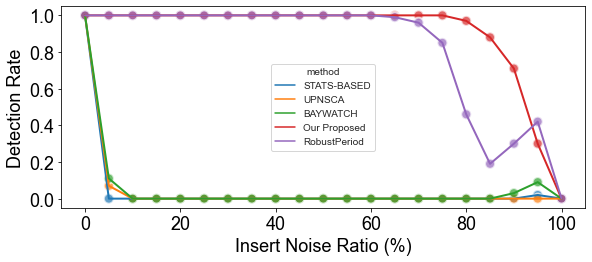

In [10]:
stats_per10 = statsdf_all.loc[statsdf_all["per"]==600]

fig, ax0 = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8, 4))
#fig = plt.figure(figsize=(6,4))
sns.set_style("whitegrid")
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False

sns.set_palette("tab10")

ax0 = sns.scatterplot(data=stats_per10, x = "omt", y="acc", hue="method", x_jitter=100, y_jitter=100,  linewidth=2, alpha=0.7, s=100, ax=ax0, legend = False)
ax0 = sns.lineplot(data=stats_per10, x = "omt", y="acc", hue="method", markers="acc", linewidth=2, ax=ax0, legend = True)

ax0.set_ylabel("Detection Rate",  fontsize=18)
ax0.set_xlabel("Insert Noise Ratio (%)",  fontsize=18)
ax0.tick_params(axis='x', labelsize=18)
ax0.tick_params(axis='y', labelsize=18)
ax0.set_yticks(np.arange(0, 1.2, step=0.2))
#ax1 = sns.scatterplot(data=stats_per60, x = "omt", y="acc", hue="method", x_jitter=100, y_jitter=100,  linewidth=2, alpha=0.7, s=100, ax=ax1)
#ax1 = sns.lineplot(data=stats_per60, x = "omt", y="acc", hue="method", markers="acc", linewidth=2, ax=ax1)

#ax1.set_ylabel("Detection Rate",  fontsize=18)
#ax1.set_xlabel("Omitting Probability (%)",  fontsize=18)
#handle, labels = ax0.get_legend_handles_labels()
#plt.legend(labels=[labels[0], labels[1], labels[2], labels[4], labels[3]], handles= [handle[0], handle[1], handle[2], handle[4], handle[3]], 
#           loc='lower center', bbox_to_anchor=(-0.1, 0.98),
#          ncol=5, fancybox=False, shadow=False, fontsize=18)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.subplots_adjust(0.07, 0.15, 0.98, 0.85)

#### RobustPeriods Demo
- Run the following blocks to check the computation time for robust periods to process one time series
- It usually took 40 seconds for one time series


In [11]:
demo_sigdf = gen_signal_df(period=10, std=0., omit_rate=0.1, count=1)
print(demo_sigdf)

start_t = time.time()
demo_res = robustper_wrap(demo_sigdf)
end_t = time.time()
print("Processing time is: {} seconds".format(end_t - start_t))

                                                 tdf  ts_cnt
0  [5.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, ...    1440
Processing time is: 36.07762622833252 seconds


#### RobustPeriods Rerun
- Run the following blocks to recompute the whole evaluation session
- Note that it usually takes hours to finish. 

In [6]:
stats_robust = pd.DataFrame(columns=["per", "std", "omt", "acc", "method"]) 

for per_m in perl:
    per = per_m * 60 # minute to seconds
    print("Generating Signals of Periodicity: {} minutes".format(per_m))
    
    for value in omtl[-5:]:
        omt = float(value)/100
        print("Gaussian Noise Level: {} %".format(value))
        datafpath = os.path.join(datarootdir, datafilefmt.format("{0:03d}".format(per_m), "{0:03d}".format(value)))
        print(datafpath)
        
        # Load or generate simulated signals
        if not regenerate and os.path.exists(datafpath):
            print("Loading data...")
            sigdf = pd.read_parquet(datafpath)
        else:
            print("ReGenerating data...")
            sigdf = gen_signal_df(per, std, omit_rate=omt, count=cnt)
            print("Saving data...")
            sigdf.to_parquet(datafpath, index=False)

        if multiproc: 
            print("Processing RobustPeriod detection...")
            robust_resdf = mltproc_robustper_wrap(sigdf, maxproc=processors)
        else:
            print("Processing RobustPeriod detection...")
            robust_resdf = robustper_wrap(sigdf)
        
        print("Getting Stats...")
        robust_acc = get_acc(robust_resdf, totalcnt=cnt)
        
        print("PERIODS:{}, STD: {}, OMT: {} \nRobustPeriods: {}\n".format(per_m, std, omt, robust_acc))
        
        ## update statatistic dataframe for plotting.
        stats_robust = stats_robust.append({"per": per, "std": std, "omt": value, "acc": robust_acc, "method": "RobustPeriod"}, ignore_index=True)
        clear_output(wait=True)

Gaussian Noise Level: 100 %
data/omt/per_060_omt_100.parquet
Loading data...
Processing RobustPeriod detection...
Getting Stats...
PERIODS:60, STD: 0.0, OMT: 1.0 
RobustPeriods: 0.0



In [17]:
stats_robust.to_csv("results/omt_robust.csv", index=False)